# Анализ оттока клиентов для сети финтнес-центров

Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных.

Распространённая проблема фитнес-клубов и других сервисов — отток клиентов. 
Для фитнес-центра можно считать, что клиент попал в отток, если за последний месяц ни разу не посетил спортзал. Конечно, не исключено, что он уехал на Бали и по приезде обязательно продолжит ходить на фитнес. Однако чаще бывает наоборот. Если клиент начал новую жизнь с понедельника, немного походил в спортзал, а потом пропал — скорее всего, он не вернётся.

Чтобы бороться с оттоком, отдел по работе с клиентами «Культуриста-датасаентиста» перевёл в электронный вид множество клиентских анкет. Наша задача — провести анализ и подготовить план действий по удержанию клиентов.
А именно:
- научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
- сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
- проанализировать основные признаки, наиболее сильно влияющие на отток;
- сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
   - выделить целевые группы клиентов;   
   - предложить меры по снижению оттока;   
   - определить другие особенности взаимодействия с клиентами.

## Загрузка данных

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, roc_auc_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings("ignore")

In [2]:
# настроим графики и отображения чисел с плавающей запятой 
pd.options.display.float_format = '{:,.4f}'.format
sns.set()

In [3]:
df = pd.read_csv('/datasets/gym_churn.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

Видим, что отсуствуют пропуски данных. Поправим названия столбцов и тип данных для некоторых столбцов

In [4]:
# приведем имена колонок к строчному виду
df.columns = df.columns.str.lower()

# исправим тип данных в столбце month_to_end_contract
df['month_to_end_contract'] = df['month_to_end_contract'].astype('int64')

In [5]:
print('Кол-во дубликатов строк: ', df.duplicated().sum())

Кол-во дубликатов строк:  0


In [6]:
df.head()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,1,1,1,1,0,6,1,29,14.2275,5,3,0.0204,0.0000,0
1,0,1,0,0,1,12,1,31,113.2029,12,7,1.9229,1.9102,0
2,0,1,1,0,1,1,0,28,129.4485,1,2,1.8591,1.7365,0
3,0,1,1,1,1,12,1,33,62.6699,12,2,3.2056,3.3572,0
4,1,1,1,1,1,1,0,26,198.3623,1,3,1.1139,1.1201,0


Загрузка и предобработка данных произведена, можно приступать к анализу.

## Исследовательский анализ данных (EDA)

### Изучение полноты данных, средних значений, стандартного отклонения

In [7]:
 df.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,"4,000.0000","4,000.0000","4,000.0000","4,000.0000","4,000.0000","4,000.0000","4,000.0000","4,000.0000","4,000.0000","4,000.0000","4,000.0000","4,000.0000","4,000.0000","4,000.0000"
mean,0.5102,0.8452,0.4868,0.3085,0.9035,4.6813,0.4123,29.1842,146.9437,4.3228,3.7247,1.8790,1.7671,0.2652
std,0.5000,0.3617,0.4999,0.4619,0.2953,4.5497,0.4923,3.2584,96.3556,4.1913,3.7493,0.9722,1.0529,0.4415
min,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,18.0000,0.1482,1.0000,0.0000,0.0000,0.0000,0.0000
25%,0.0000,1.0000,0.0000,0.0000,1.0000,1.0000,0.0000,27.0000,68.8688,1.0000,1.0000,1.1809,0.9630,0.0000
50%,1.0000,1.0000,0.0000,0.0000,1.0000,1.0000,0.0000,29.0000,136.2202,1.0000,3.0000,1.8328,1.7196,0.0000
75%,1.0000,1.0000,1.0000,1.0000,1.0000,6.0000,1.0000,31.0000,210.9496,6.0000,5.0000,2.5361,2.5103,1.0000
max,1.0000,1.0000,1.0000,1.0000,1.0000,12.0000,1.0000,41.0000,552.5907,12.0000,31.0000,6.0237,6.1468,1.0000


**Выводы:**
- Распределение по полу среди клиентов фитнес клуба примерно равное
- Почти 85 % клиентов живут или работают в непосредственной близости от фитнес-клубов «Культурист-датасаентист»
- Почти половина клиентов являются сотрудниками компании-партнёра клуба
- Только 31% клиентов  использовали промо-код от знакомого при оплате первого абонемента (по акции "Приведи друга")
- 10% клиентов отказались давать свой контактный номер телефона
- Средняя продолжительность абонемента составляет 4,6 месяца
- Имеется сильный разброс продолжительности абонементов, среднеквадратичное отклонение составляет 4,5 месяца
- 41% клиетов ходит на групповые занятия
- Средний возраст клиентов - 29,2 лет, при этом можно сказать что сильные колебания данного показателя отсутствуют, среднеквадратичное отклонение составляет всего 3,2 года. Самому молодому клиенту - 18 лет, самому возрастному -41 год.
- Средняя суммарная выручка от дополнительных услуг на 1 клиента составляет 146$ на человека
- Средний лайфтайм наших клиентов составляет 3,7 месяца, при этом у нас есть клиенты, которые пользовались нашими услугами целых 31 месяц
- В среднем, каждый клиент посещал наши фитнес-центры 1,8 раз в месяц. Только 25% клиентов посещали нас больше, чем 2,5 раза в месяц, максимальное значение среднего числа посещений - 6,1 раз в месяц
- 26,5% клиентов "ушли" из нашей сети фитнес-клубов в текущем месяце

### Изучение средних значений признаков в группах клиентов

In [8]:
df.groupby(['churn']).mean().T

churn,0,1
gender,0.5100,0.5108
near_location,0.8731,0.7681
partner,0.5342,0.3553
promo_friends,0.3535,0.1838
phone,0.9037,0.9029
contract_period,5.7472,1.7286
group_visits,0.4641,0.2686
age,29.9765,26.9896
avg_additional_charges_total,158.4457,115.0829
month_to_end_contract,5.2831,1.6626


**Выводы:**
- среди ушедших поровну мужчин и женщин
- клиенты, которые живут или работаю не  в районе, где находится фитнес-центр, чаще на 11% отказываются от наших услуг
- в отток клиентов больше попадают люди, не являющиеся сотрудниками компании-партнёры клуба (на 17,88% больше по сравнению с клиентами, решившими остаться с нами)
- в отток клиентов больше попадают люди, не воспользовавшиеся промо-кодом от знакомого при оплате первого абонемента (на 16,98% больше по сравнению с клиентами, решившими остаться с нами)
- наличие телефона в профайле клиента никак не влияет на шанс его оттока
- средняя продолжительность абонемента у "оставшихся" клиентов -5,7 месяцев, решивших уйти - 1,7 месяца
- ушедшие клиенты меньше в среднем посещают групповые занятия
- среди ушедших клиентов ниже средний возраст по сравнению с оставшимися клиентами - 27 лет против 30
- среди ушедших меньше средний чек за сопутствующие услуги нашего фитнес-центра
- среди ушедших значительно меньше среднее количество месяцев до окончания контракта - 1,7 против 5,2 у оставшихся
- средний лайфтайм среди ушедших - 1 месяц. Люди бросают занятия в среднем после 1 месяца занятий
- в среднем,  ушедшие клиенты посещали фитнес 1,47 раза в неделю с начала покупки абонемента и 1,05 раз в неделю в последний месяц, в то время как оставшиеся клиенты стабильно ходят по 2 раза в месяц на занятия

### Постройка столбчатых гистограмм и распределения признаков по группам клиентов 

Для анализа поделим датасет на 2: группу оставшихся и группу оттока. Все поля условно разделим на 2: количественные признаки и бинарные данные, для которых возможно только два показателя (1 или 0)

In [9]:
quantitative_columns = ['avg_additional_charges_total', 'avg_class_frequency_total', 
                    'avg_class_frequency_current_month', 'lifetime', 'age', 
                    'contract_period', 'month_to_end_contract']
binary_columns = ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'group_visits']

churn = df.query('churn== 1')
stay = df.query('churn== 0')

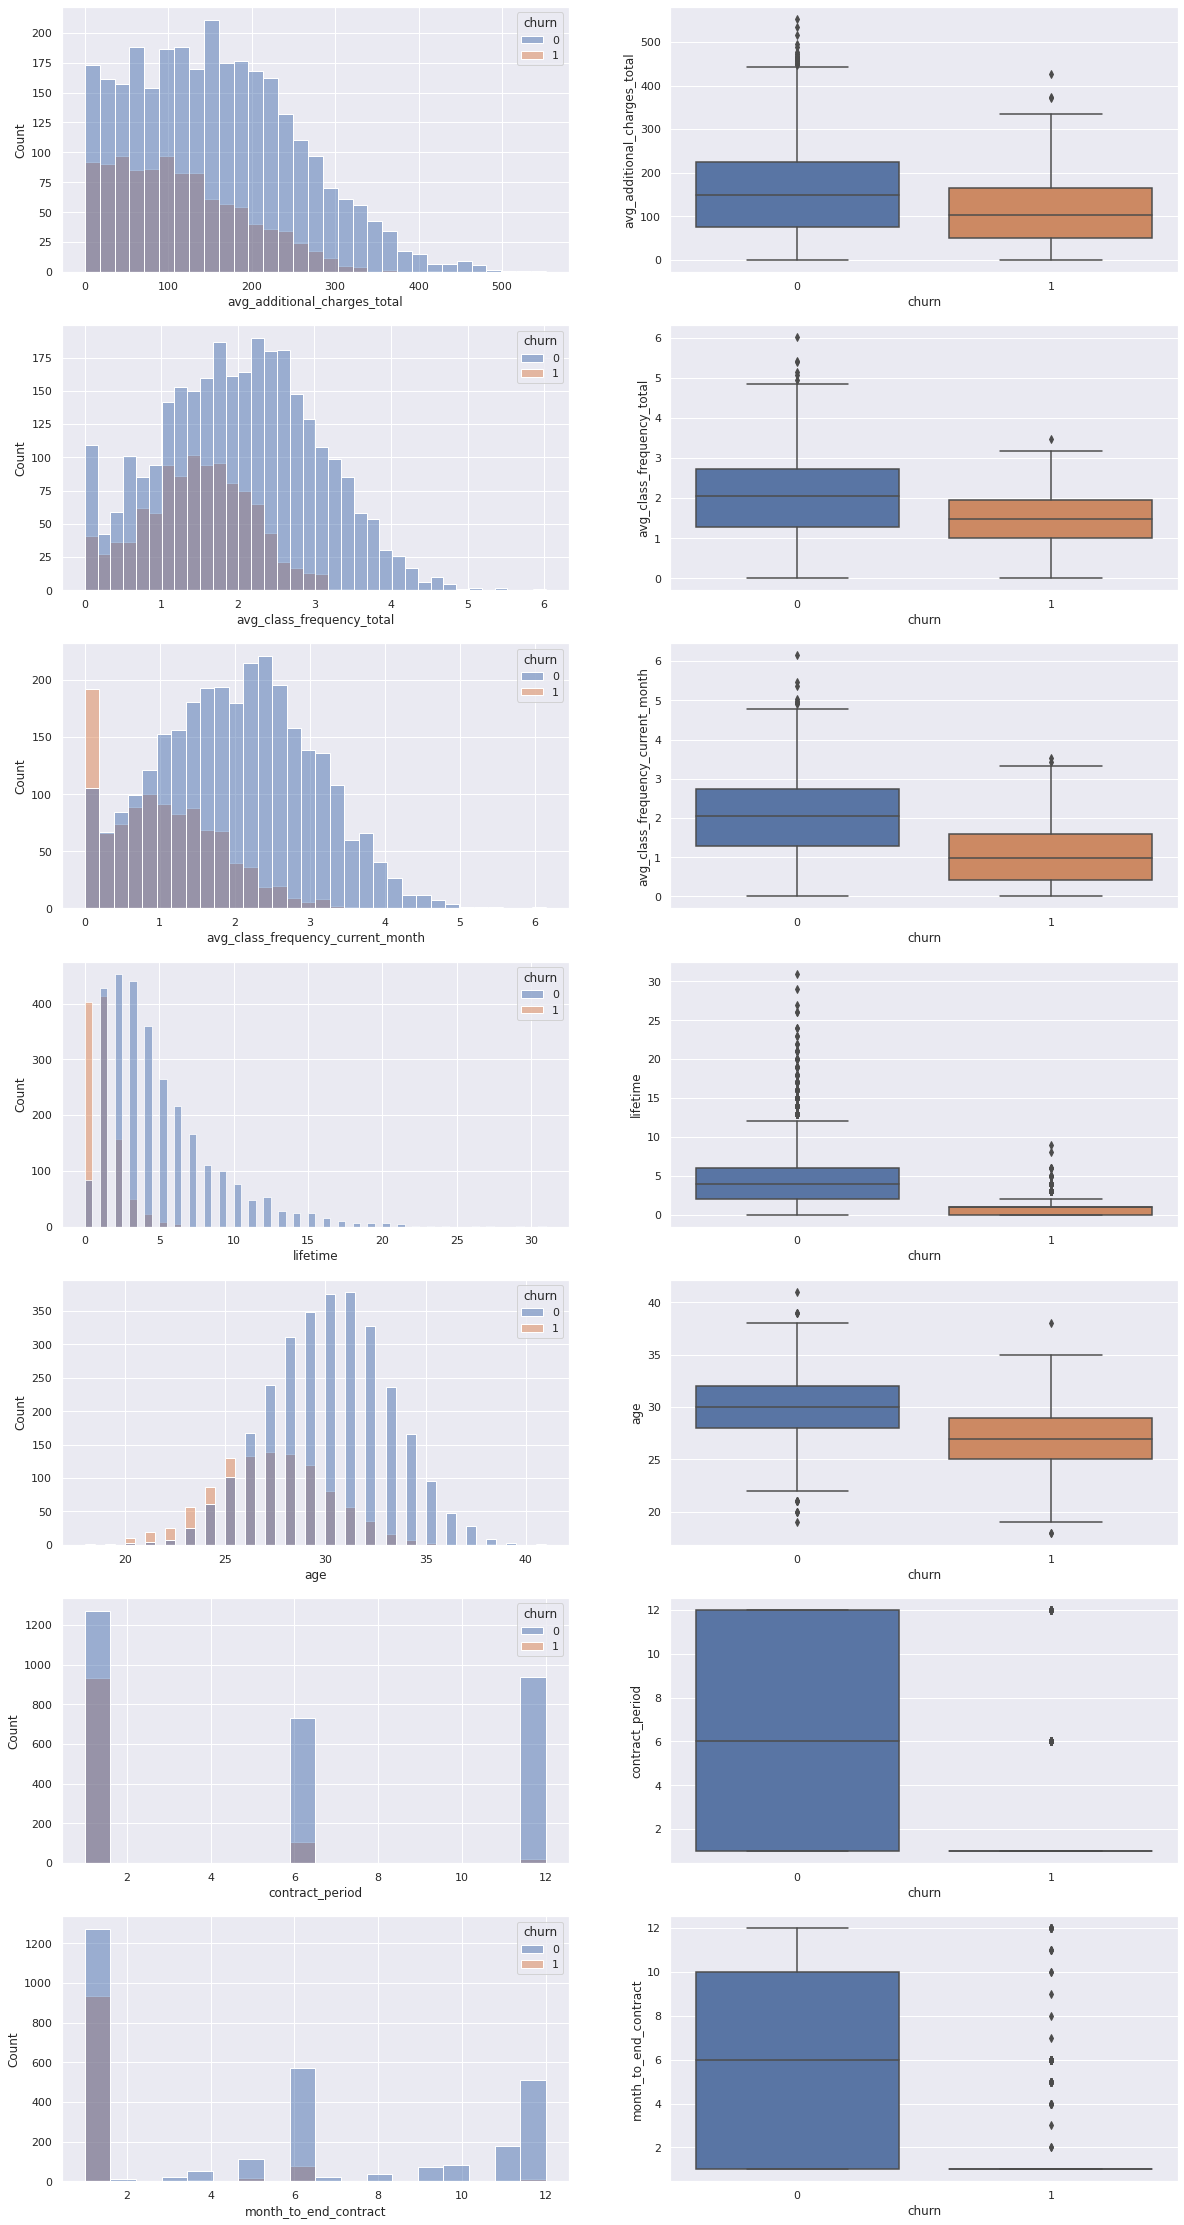

<Figure size 720x288 with 0 Axes>

<Figure size 720x288 with 0 Axes>

<Figure size 720x288 with 0 Axes>

<Figure size 720x288 with 0 Axes>

<Figure size 720x288 with 0 Axes>

<Figure size 720x288 with 0 Axes>

<Figure size 720x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [10]:
fig, axs = plt.subplots(7, 2, figsize=(20,40))
for idx, ax in enumerate(axs):
    
    plt.figure(figsize=(10,4)) 
    column = quantitative_columns[idx]
    sns.histplot(data = df, x = column, hue = 'churn' , ax = ax[0] )
    sns.boxplot(x = 'churn', y = df[column], data = df, ax = ax[1])

plt.show()
plt.tight_layout()

Данные группы графиков хорошо демонстрируют основные различия между группами оставшихся и ушедших клиентов:
- медианное значение дополнительной выручки с клиента ниже и составляет `100$` против `150$` у оставшихся.
- среднее число посещений в текущий месяц/неделю ниже у группы оттока. Можно сделать вывод, что если клиент посещает более 3-х занятий в месяц, то он точно "обезопасен" от попадания в группу оттока. Так же большинство ушедших клиентов вообще не посещало занятие в последний месяц
- наибольший  отток с у клиентов с lifetime в 1-2 месяца и продолжительностью контракта в 1 месяц
- медианное значение возраста в группе ушедших ниже

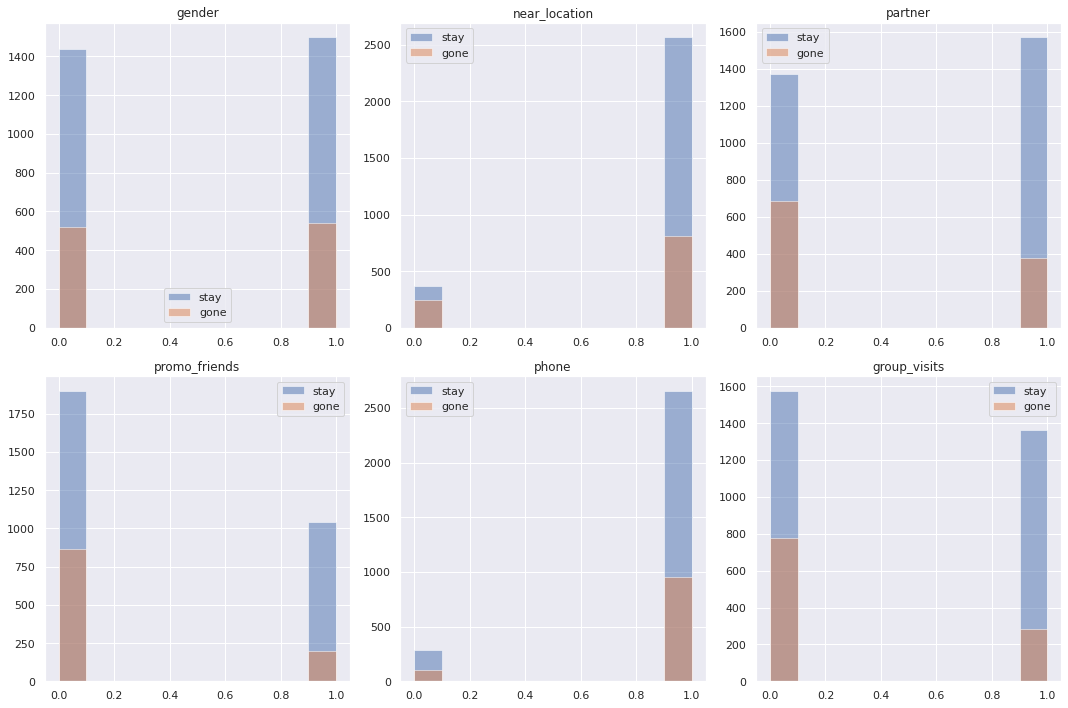

In [11]:
fig, axs = plt.subplots(2, 3, figsize=(15,10))
axs = axs.ravel()
for idx, ax in enumerate(axs):
    column = binary_columns[idx]
    ax.hist(stay[column], label="stay", alpha=0.5)
    ax.hist(churn[column], label="gone", alpha=0.5)
    ax.set_title(column)
    ax.legend()
plt.tight_layout()

Данная группа графиков в целом подтверждает выводы, сделанные в п.2.2 исследования.

### Постройка матрицы корреляции

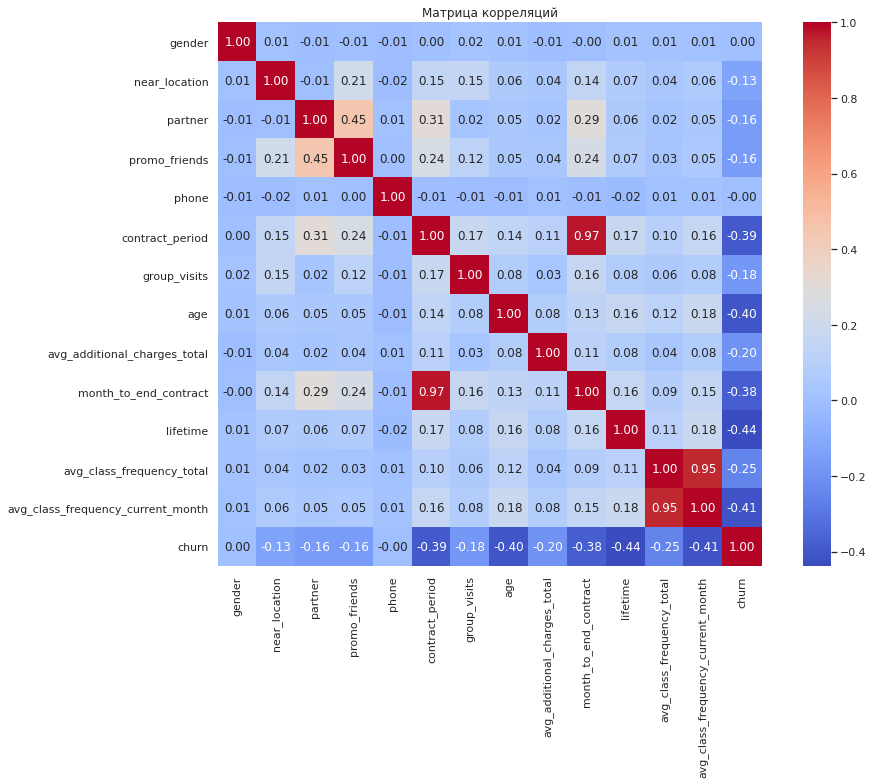

In [12]:
corr_m = df.corr()
plt.figure(figsize=(15,10))
sns.heatmap(corr_m, square = True, annot = True, fmt = '0.2f', cmap= 'coolwarm')# нарисуем heatmap
plt.title('Матрица корреляций')
plt.show()

Есть две пары мультиколлинеарных признаков (корреляция больше 0,8 по модулю значения): 

`Contract_period` - `Month_to_end_contract`

`Avg_class_frequency_current_month` - `Avg_additional_charges_total`

Остальные признаки слабо скоррелированны между собой.


## Модель прогнозирования оттока клиентов

In [13]:
# создадим функцию для вывода метрик 
def print_all_metrics(y_true, y_pred, y_proba, title = 'Метрики классификации'):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))
    print('\tF1: {:.2f}'.format(f1_score(y_true, y_pred)))
    print('*'*50)

In [14]:
X = df.drop(['churn'], axis = 1)
y = df['churn']
# разделяем модель на обучающую и валидационную выборки
# c добавлением параметра stratify для сохранения пропроций набора данных
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0,  stratify=y)

scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train)
X_test_st = scaler.transform(X_test)


lr_model = LogisticRegression(random_state=0)
lr_model.fit(X_train_st, y_train)
lr_predictions = lr_model.predict(X_test_st)
lr_probabilities = lr_model.predict_proba(X_test_st)[:,1]

print_all_metrics(y_test, lr_predictions, lr_probabilities , title='Метрики для модели логистической регрессии:')

rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0) 
rf_model.fit(X_train_st, y_train)
rf_predictions = rf_model.predict(X_test_st)
rf_probabilities = rf_model.predict_proba(X_test_st)[:,1]

print_all_metrics(y_test, rf_predictions, rf_probabilities , title='Метрики для модели случайного леса:')

Метрики для модели логистической регрессии:
	Accuracy: 0.94
	Precision: 0.90
	Recall: 0.85
	F1: 0.87
**************************************************
Метрики для модели случайного леса:
	Accuracy: 0.92
	Precision: 0.88
	Recall: 0.83
	F1: 0.85
**************************************************


Лучшие результаты показала модель логистической регрессии.

Доля правильных ответов - 94%, точность - 90%, полнота - 85%, f1 мера- 87%. Хороший результат.

## Создание кластеризации клиентов

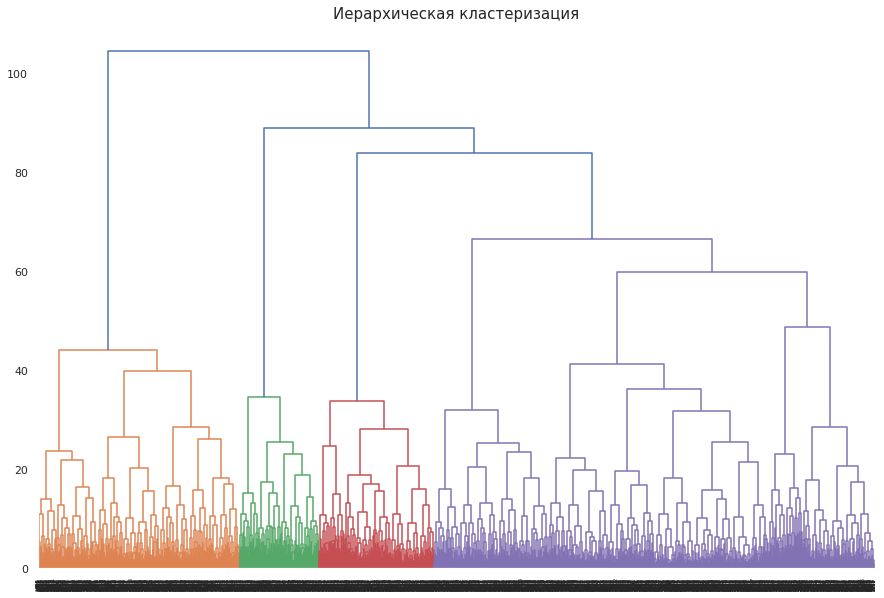

In [15]:
X_st = scaler.fit_transform(X)
linked = linkage(X_st, method='ward')
plt.figure(figsize=(15, 10))
dendrogram(linked, orientation='top')
plt.title('Иерархическая кластеризация', fontsize=15)
plt.show()

Согласно дереву иерархической кластеризации оптимальное число кластеризации - 4

Согласно условиям задачи обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов. Примем  число кластеров равное 5.

In [16]:
km = KMeans(n_clusters = 5, random_state = 0)
labels = km.fit_predict(X_st)
df['cluster_km'] = labels

In [17]:
df.groupby('cluster_km').mean().T

cluster_km,0,1,2,3,4
gender,0.5030,0.5221,0.4950,0.4857,0.5597
near_location,0.9594,0.8623,0.0000,1.0000,0.9761
partner,0.7832,0.4701,0.4634,0.3502,0.3568
promo_friends,0.5743,0.3065,0.0792,0.2401,0.2303
phone,1.0000,0.0000,1.0000,1.0000,0.9988
contract_period,10.8891,4.7870,2.3525,1.9485,2.6695
group_visits,0.5426,0.4260,0.2158,0.3415,0.4737
age,29.9822,29.3013,28.4772,28.1680,30.1253
avg_additional_charges_total,160.7610,143.9577,135.4575,131.6222,161.6579
month_to_end_contract,9.9545,4.4753,2.1980,1.8566,2.4594


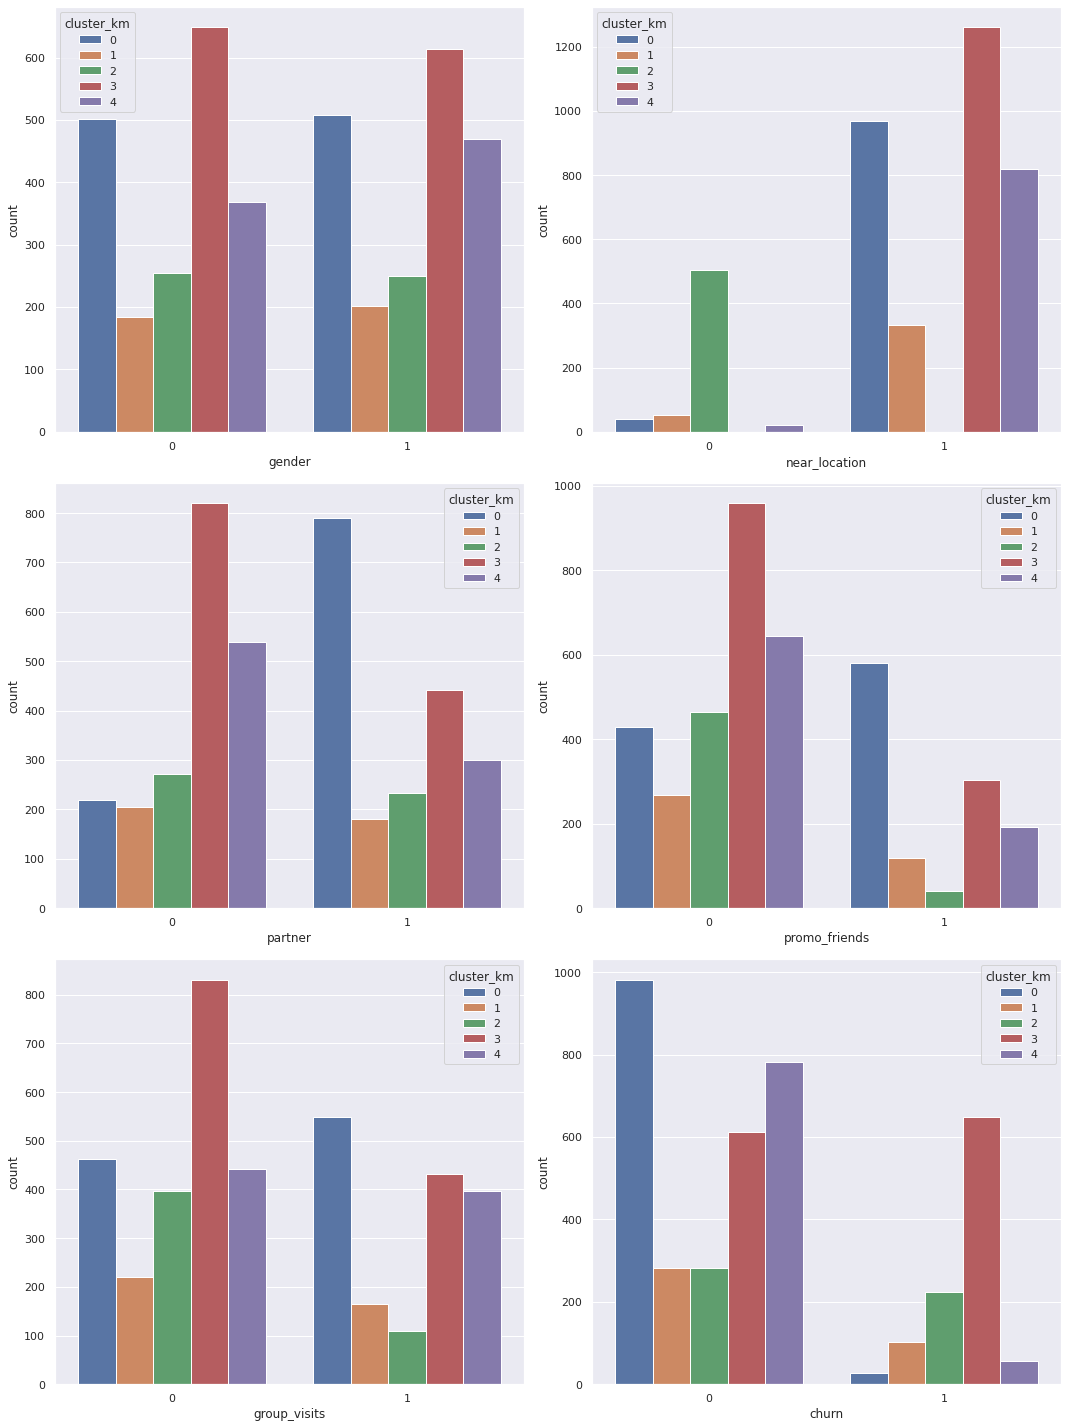

In [18]:
column_cluster= ['gender', 'near_location', 'partner', 'promo_friends', 
                       'group_visits', 'churn']

fig, axs = plt.subplots(3, 2, figsize=(15,20))
axs = axs.ravel()

for idx, ax in enumerate(axs):
    column = column_cluster[idx]
    sns.countplot(data = df, x = column, hue='cluster_km', ax = ax)
plt.tight_layout()

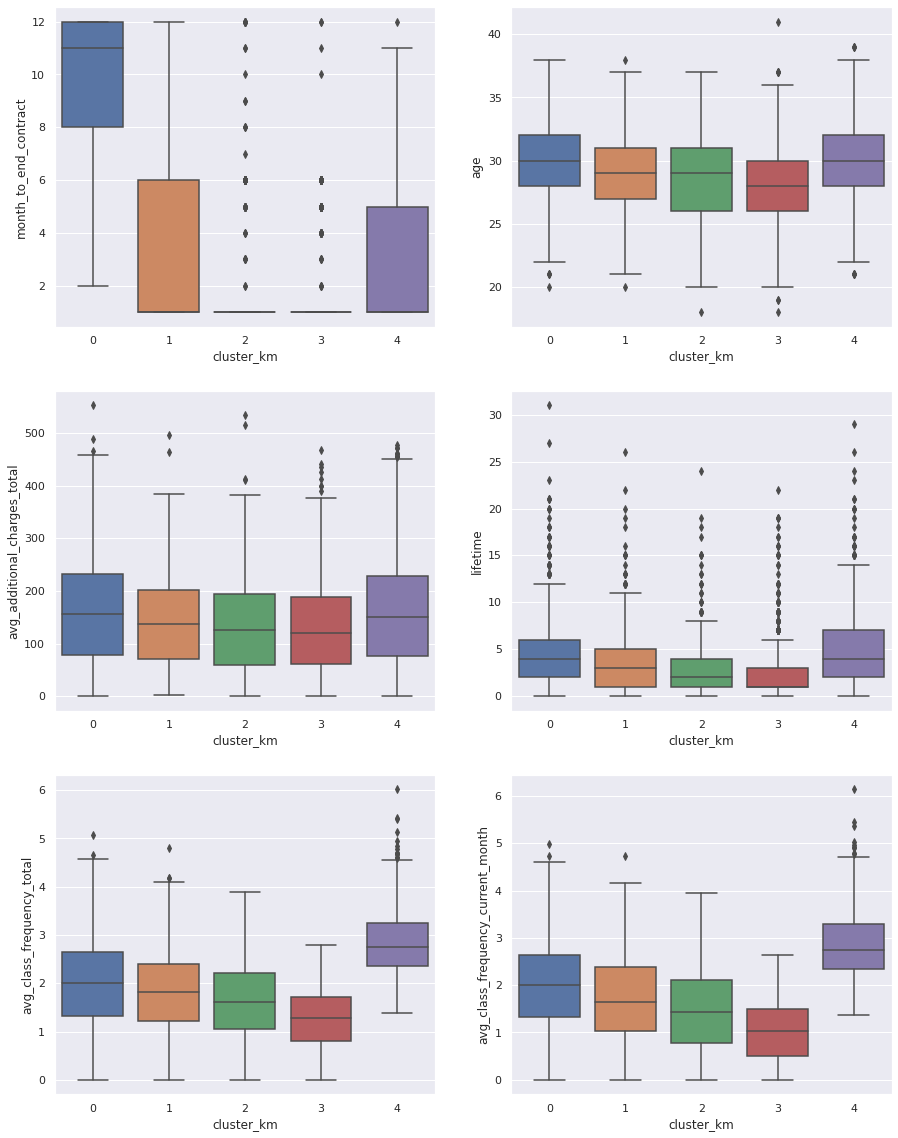

<Figure size 432x288 with 0 Axes>

In [19]:
boxplot_columns = ['month_to_end_contract', 'age', 'avg_additional_charges_total', 'lifetime', 
                   'avg_class_frequency_total', 'avg_class_frequency_current_month']

fig, axs = plt.subplots(3, 2, figsize=(15,20))
axs = axs.ravel()

for idx, ax in enumerate(axs):
    column = boxplot_columns[idx]
    sns.boxplot(x = 'cluster_km', y = df[column], data = df, ax = ax)

plt.show()
plt.tight_layout()

Итак, с помощью модели кластеризации получили 5 кластера:

*Кластер 0*
- живут и работают рядом с фитнес-центрами
- **78% клиентов пришли по партнерской программе** - максимальный результат среди всех класстеров
- **57% клиентов пришли по акции "Приведи друга"** - максимальный результат среди всех класстеров
- в группу входят клиенты с максимальными продолжительностью контрактов, и предмаксимальными значениями по выручке с клиента, лайфтаймом
- 54% клиентов посещают групповые занятия
- стабильно ходят почти 2 раза в месяц на протяжении всего периода на занятия
- **минимальный процент оттока клиентов- всего 2,7%**

*Кластер 1*
- в основном живут и работаю рядом с фитнес-центрами
- нет данных о контактных телефонов
- среднестатистические показатели по процентам посещения групповых тренировок, пришедшим по партнерским программам и акции "Приведи друга", выручки с 1 клиента, показателям по количеству посещаемых тренировок в месяц
- средняя продолжительность контракта в группе - 4,7 месяца, лайфтайм -3,9 месяца
- отток - 26%, что довольно много на мой взгляд для показателей данной группы

*Кластер 2*
- **живут и работают далеко от фитнес-клуба**
- **минимальный процент пришедших по акции "Приведи друга"**
- мало посещают групповые тренировки
- средний чек с дополнительных услуг один из самых низких
- отток в 44%

*Кластер 3*
- самое высокое значение оттока клиентов - 51%
- **реже всех посещают фитнес-кубы**
- наименьшая продолжительность контракта - до 1,9 месяца в среднем
- минимальная выручка с дополнительных услуг

*Кластер 4* 
- Процент ушедших клиентов - 6,8%
- маленькая доля клиентов пришла по партнерской программе и акции "Приведи друга"
- средняя продолжительность контракта - 2,6 месяца, лайфиайм 4,8 месяца
- большая доля посещающих ходят на групповые занятия
- **рекордсмены по количеству посещений   фитнес-центров в последний месяц и в среднем, 2,8 визита**
- **наивысшая дополнительная выручка с клиента в данной группе - `161$` в среднем**

## Выводы и базовые рекомендации по работе с клиентами

**Первоначальный анализ данных показал:**
- Распределение по полу среди клиентов фитнес клуба примерно равное
- Почти 85 % клиентов живут или работают в непосредственной близости от фитнес-клубов «Культурист-датасаентист»
- Почти половина клиентов являются сотрудниками компании-партнёра клуба
- Только 31% клиентов  использовали промо-код от знакомого при оплате первого абонемента (по акции "Приведи друга")
- 10% клиентов отказались давать свой контактный номер телефона
- Средняя продолжительность абонемента составляет 4,6 месяца
- Имеется сильный разброс продолжительности абонементов, среднеквадратичное отклонение составляет 4,5 месяца
- 41% клиентов ходят на групповые занятия
- Средний возраст клиентов - 29,2 лет, при этом можно сказать что сильные колебания данного показателя отсутствую, среднеквадратичное отклонение составляет всего 3,2 года. Самому молодому клиенту - 18 лет, самому возрастному -41 год.
- Средняя суммарная выручка от дополнительных услуг на 1 клиента составляет `146$` на человека
- Средний лайфтайм наших клиентов составляет 3,7 месяца, при этом у нас есть клиенты, которые пользовались нашими услугами целых 31 месяц
- В среднем, каждый клиент посещал наши фитнес-центры 1,8 раз в месяц. Только 25% клиентов посещали нас больше, чем 2,5 раза в месяц, максимальное значение среднего числа посещений - 6,1 раз в месяц
- 26,5% клиентов "ушли" из нашей сети фитнес-клубов в текущем месяце


**Анализ клиентов по группам ушедших в отток/оставшихся клиентов:**
- среди ушедших поровну мужчин и женщин
- клиенты, которые живут или работаю не  в районе, где находится фитнес-центр, чаще на 11% отказываются от наших услуг
- в отток клиентов больше попадают люди, не являющиеся сотрудниками компании-партнёры клуба (на 17,88% больше по сравнению с клиентами, решившими остаться с нами)
- в отток клиентов больше попадают люди, не воспользовавшиеся промо-кодом от знакомого при оплате первого абонемента (на 16,98% больше по сравнению с клиентами, решившими остаться с нами)
- наличие телефона в профайле клиента никак не влияет на шанс его оттока
- средняя продолжительность абонемента у "оставшихся" клиентов - 5,7 месяца, решивших уйти - 1,7 месяца
- ушедшие клиенты меньше в среднем посещают групповые занятия
- среди ушедших клиентов ниже средний возраст по сравнению с оставшимися клиентами - 27 лет против 30
- среди ушедших меньше средний чек за сопутствующие услуги нашего фитнес-центра
- среди ушедших значительно меньше среднее количество месяцев до окончания контракта - 1,7 против 5,2 у оставшихся
- средний лайфтайм среди ушедших - 1 месяц. Люди бросают занятия в среднем после 1 месяца занятий
- в среднем,  ушедшие клиенты посещали фитнес 1,47 раза в неделю с начала покупки абонемента и 1,05 раз в неделю в последний месяц, в то время как оставшиеся клиенты стабильно ходят по 2 раза в месяц на занятия. Можно сделать вывод, что если клиент посещает более 3-х занятий в месяц, то он точно "обезопасен" от попадания в группу оттока. Так же большинство ушедших клиентов вообще не посещало занятие в последний месяц
- наибольший  отток с у клиентов с lifetime в 1-2 месяца и продолжительностью контракта в 1 месяц
- Явная зависимость между оттоком и остальными признаками отсутствует. Есть две пары мультиколлинеарных признаков(корреляция больше 0,8 по модулю значения): `Contract_period` - `Month_to_end_contract`; `Avg_class_frequency_current_month` - `Avg_additional_charges_total`. Остальные признаки слабо скоррелированны между собой


**При построении модели бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце** лучшие результаты показала модель логистической регрессии. Доля правильных ответов - 94%, точность - 90%, полнота - 85%, f1 мера- 87%. Хороший результат..


**Произведена кластеризация пользователей на 5 групп с помощью алгоритма K-Means.** Получены кластеры:

*Кластер 0*
- живут и работают рядом с фитнес-центрами
- **78% клиентов пришли по партнерской программе** - максимальный результат среди всех кластеров
- **57% клиентов пришли по акции "Приведи друга"** - максимальный результат среди всех кластеров
- в группу входят клиенты с максимальными продолжительностью контрактов, и предмаксимальными значениями по выручке с клиента, лайфтаймом
- 54% клиентов посещают групповые занятия
- стабильно ходят почти 2 раза в месяц на протяжении всего периода на занятия
- **минимальный процент оттока клиентов - всего 2,7%**

*Кластер 1*
- в основном живут и работаю рядом с фитнес-центрами
- нет данных о контактных телефонов
- среднестатистические показатели по процентам посещения групповых тренировок, пришедшим по партнерским программам и акции "Приведи друга", выручки с 1 клиента, показателям по количеству посещаемых тренировок в месяц
- средняя продолжительность контракта в группе - 4,7 месяца, лайфтайм -3,9 месяца
- отток - 26%, что довольно много на мой взгляд для показателей данной группы

*Кластер 2*
- **живут и работают далеко от фитнес-клуба**
- **минимальный процент пришедших по акции "Приведи друга"**
- мало посещают групповые тренировки
- средний чек с дополнительных услуг один из самых низких
- отток в 44%

*Кластер 3*
- самое высокое значение оттока клиентов - 51%
- **реже всех посещают фитнес-кубы**
- наименьшая продолжительность контракта - до 1,9 месяца в среднем
- минимальная выручка с дополнительных услуг

*Кластер 4* 
- Процент ушедших клиентов - 6,8%
- маленькая доля клиентов пришла по партнерской программе и акции "Приведи друга"
- средняя продолжительность контракта - 2,6 месяца, лайфиайм 4,8 месяца
- большая доля посещающих ходят на групповые занятия
- **рекордсмены по количеству посещений   фитнес-центров в последний месяц и в среднем, 2,8 визита**
- **наивысшая дополнительная выручка с клиента в данной группе - 161$ в среднем**

**Рекомендации:**

С помощью модели класстеризации было выявлено, что наибольшему оттоку подвержены клиенты с малым количеством посещаемых занятий в месяц, малой продолжительностью абониментов.

Поэтому рекомендации очевидны:
- сделать акцент на количество посещений клиетов наших фитнес-центров. По статистике наших данных, если клиент посещает более 3-х занятий в месяц, то он почти точно "обезопасен" от попадания в группу оттока. Так же большинство ушедших клиентов вообще не посещало занятие в последний месяц
- наибольший отток среди клиентов с короткой продолжительностью абониментов - сделать акцент на приобритении контратов с большей продолжительностью
- активней привлекать клиентов по партнерской программе и акции "Приведи друга" и на посещение групповых тренировок.